### Exploration Extension: Using t-SNE to visualize the data

In [1]:
import numpy as np
import pandas as pd
import pylab
from pandas.io.json import json_normalize
import pyspark
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.ml.recommendation import ALS, ALSModel
from pyspark.sql.functions import collect_list

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

In [2]:
conf = pyspark.SparkConf().setAppName('appName').setMaster('local')
# sc = pyspark.SparkContext(conf=conf)
spark = SparkSession(sc)
# spark.conf.set('spark.sql.pivotMaxValues', u'718022')
spark.conf.set("spark.executor.memory", "30G")
spark.conf.set("spark.driver.memory", "30G")

---

In [ ]:
# Load model file which was created on dumbo. This model was built using a subset of the
# full reviews dataset following the same train/val/test split procedure as detailed
# elsewhere in this project. Key ALS hyperparamters: rank=100, lambda=0.005

# model_file = 'model_25_rank_50_lam_0.05_model.m'
model_file = 'rank_100_lam_0.005_model.m'
rank=100

# Downsample itemFactors slightly and save separately to itemFactors.parquet file
# model = ALSModel.load(model_file)
# df = model.itemFactors
# df = df.sample(False, 0.75, seed=2020)
# df.write.parquet('itemFactors.parquet')

In [51]:
itemFactors = spark.read.parquet('itemFactors.parquet')
itemFactors.createOrReplaceTempView('itemFactors')
itemFactors = itemFactors.toPandas()

In [52]:
# Remap indexed ids to book_id
book_index = pd.read_csv('item_idx_map.csv', names=['book_id', 'id'])
book_index['id'] = book_index['id'].astype(int)
itemFactors = itemFactors.merge(book_index, on='id')
itemFactors = itemFactors.drop(columns=['id'])

In [53]:
# Remap indexed ids to goodreads book_id

b_idx = spark.read.parquet('books.parquet')
b_idx.createOrReplaceTempView('b_idx')
b_idx = b_idx.toPandas()
itemFactors = itemFactors.merge(b_idx,on='book_id')
itemFactors = itemFactors.drop(columns=['book_id'])
itemFactors.columns=['features', 'book_id']
itemFactors['book_id'] = itemFactors['book_id'].astype(int)

### Vizualization by Genre

In [78]:
# Load goodreads GENRES data and parse (take a book's max # of reviews as true genre
# for that book). Save to csv for easier loading next time

# f1 = 'goodreads_book_genres_initial.json'
# g = pd.read_json(f1, lines=True)
# g1 = json_normalize(g['genres'])
# g1 = g1.fillna(0)
# g1 = g1.idxmax(axis=1)
# g2 = g['book_id']
# g = pd.concat([g2, g1], axis=1)
# g.columns=['book_id', 'genre']
# genres = g
# genres.to_csv(r'genres.csv', index = False, header=True)
genres = pd.read_csv('genres.csv')

In [79]:
#Inner join -- throw out books with no genre
df_g = itemFactors.copy()
df_g = df_g.merge(genres, on='book_id', how='inner')

In [80]:
# Take sample of 100,000 books to plot 
N = 100_000
np.random.seed(2020)
rndperm = np.random.permutation(df_g.shape[0])
df_subset = df_g.loc[rndperm[:N],:].copy()
gen = df_subset['genre']
# df_subset = df

In [81]:
# Make array of feature values for subsample
feat_cols = ['feat'+str(i) for i in range(1, rank+1)]
features = pd.DataFrame(df_subset['features'].to_list(), columns=feat_cols)
data_subset = features.values

In [90]:
# First use PCA to reduce dimensions from 100 to 50
pca = PCA(n_components=50)
pca_result = pca.fit_transform(data_subset)
df_subset['pca-one'] = pca_result[:,0]
df_subset['pca-two'] = pca_result[:,1]
df_subset['pca-three'] = pca_result[:,2]
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.15728191 0.07802227 0.02109958 0.0179351  0.01664922 0.01583281
 0.01468853 0.01352145 0.01287562 0.01158458 0.01142338 0.01068661
 0.0104992  0.01005023 0.00977596 0.00961088 0.0093501  0.00925606
 0.00910893 0.0089841  0.00893494 0.00866299 0.00856453 0.00850193
 0.00837715 0.00819128 0.00813466 0.00809668 0.00804196 0.00800994
 0.00791928 0.00782031 0.00767598 0.00763879 0.00760288 0.00749008
 0.00742321 0.00734665 0.00730068 0.00721431 0.00714908 0.00704672
 0.00701724 0.00697508 0.0069499  0.00693742 0.00684839 0.00682809
 0.00672315 0.00665029]


In [91]:
# Now use TSNE to reduce to 2 dimensions
tsne = TSNE(n_components=2, learning_rate=500, perplexity=50, n_iter=1000)
tsne_results = tsne.fit_transform(pca_result)
# tsne_results = tsne.fit_transform(data_subset)
print('t-SNE done')

t-SNE done


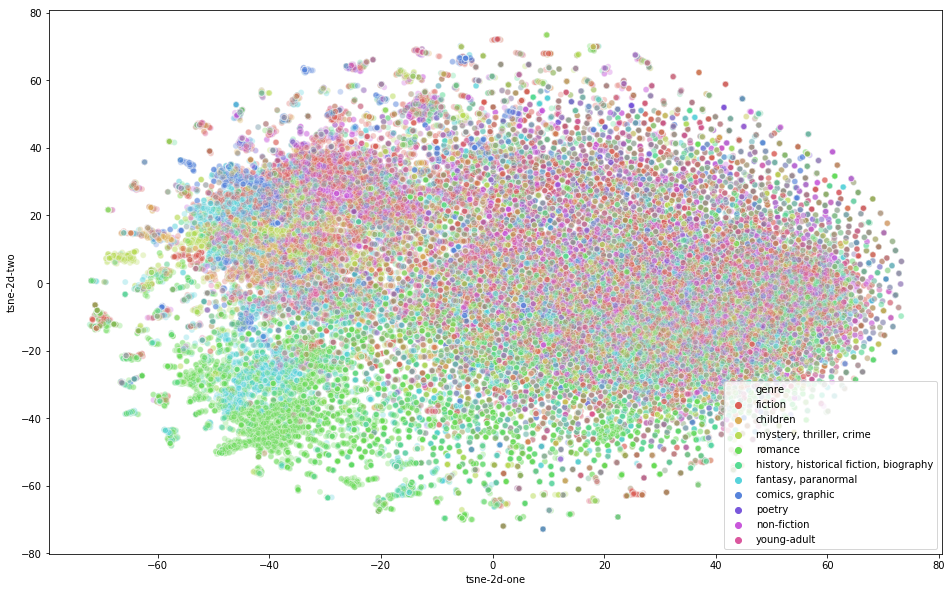

In [92]:
#Plot results
df_subset['tsne-2d-one'] = tsne_results[:,0]
df_subset['tsne-2d-two'] = tsne_results[:,1]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="genre",
    palette=sns.color_palette("hls", 10),
    data=df_subset,
    legend="full",
    alpha=0.3
)

---

### Vizualization by Publication Decade

In [93]:
# Use spark on local machine to pull book_id and pub_year from book metadata file (large)
# Write to csv on local machine for easier usage later

# df_yrs = spark.read.json('goodreads_books_metadata.json')
# df_yrs.createOrReplaceTempView('df_yrs')
# df_yrs = df_yrs.select('book_id', 'publication_year')
# df_yrs.write.parquet('pub_years.parquet')
# years = spark.read.parquet('pub_years.parquet')
# years.createOrReplaceTempView('years')
# years = years.toPandas()
# years['publication_year'] = years['publication_year'].apply(pd.to_numeric)
# years = years.dropna() #drop books with no year
# years['decade'] = np.floor(years['publication_year'] / 10.0) * 10
# years = years.drop(columns=['publication_year'])
# years.to_csv(r'years.csv', index = False, header=True)

In [94]:
# Load publication year data
years = pd.read_csv('years.csv')
years = years.fillna(0)

In [95]:
# Join learned factors with year data and drop books with no or incorrect pub_year
df_y = itemFactors.copy()
df_y = df_y.merge(years, on='book_id', how='inner') #drop books with no pub_year
df_y['decade'] = df_y['decade'].astype(int)
df_y = df_y.fillna(0)
# Drop books with pub_years that don't make sense or from decades with very few books
df_y = df_y.drop(df_y[df_y['decade'] < 1920].index)
df_y = df_y.drop(df_y[df_y['decade'] > 2010].index)
df_y = df_y.dropna()

In [96]:
# Sample
N = 100000
np.random.seed(2020)
rndperm = np.random.permutation(df_y.shape[0])
df_subset = df_y.loc[rndperm[:N],:].copy()

/Users/kevinwilson/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


In [97]:
# Make array of feature values for subsample
df_subset = df_subset.dropna()
df_subset['book_id'] = df_subset['book_id'].astype(int)
feat_cols = ['feat'+str(i) for i in range(1, rank+1)]
features = pd.DataFrame(df_subset['features'].to_list(), columns=feat_cols)
data_subset = features.values

In [98]:
# First use PCA to reduce dimensions
pca = PCA(n_components=50)
pca_result = pca.fit_transform(data_subset)
df_subset['pca-one'] = pca_result[:,0]
df_subset['pca-two'] = pca_result[:,1]
df_subset['pca-three'] = pca_result[:,2]
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.15981324 0.07458623 0.02160571 0.01786808 0.01690805 0.01596825
 0.01478497 0.01357418 0.01308365 0.01188187 0.01141022 0.01096577
 0.0105442  0.01027885 0.00975034 0.00956423 0.00941929 0.00933642
 0.00904309 0.00892358 0.00884251 0.00873629 0.00863052 0.00853939
 0.00833088 0.0082176  0.00812376 0.00800719 0.00793572 0.00793032
 0.00777878 0.00775013 0.00768011 0.0076074  0.00757208 0.00743014
 0.00742148 0.00736807 0.00725543 0.00720561 0.00717111 0.00711632
 0.00701006 0.00693516 0.00689761 0.00685765 0.0067939  0.0067273
 0.00666473 0.00660902]


In [99]:
# Now use TSNE
tsne = TSNE(n_components=2, verbose=0, perplexity=50, n_iter=1000)
tsne_results = tsne.fit_transform(pca_result)
# tsne_results = tsne.fit_transform(data_subset)
print('t-SNE done')

t-SNE done


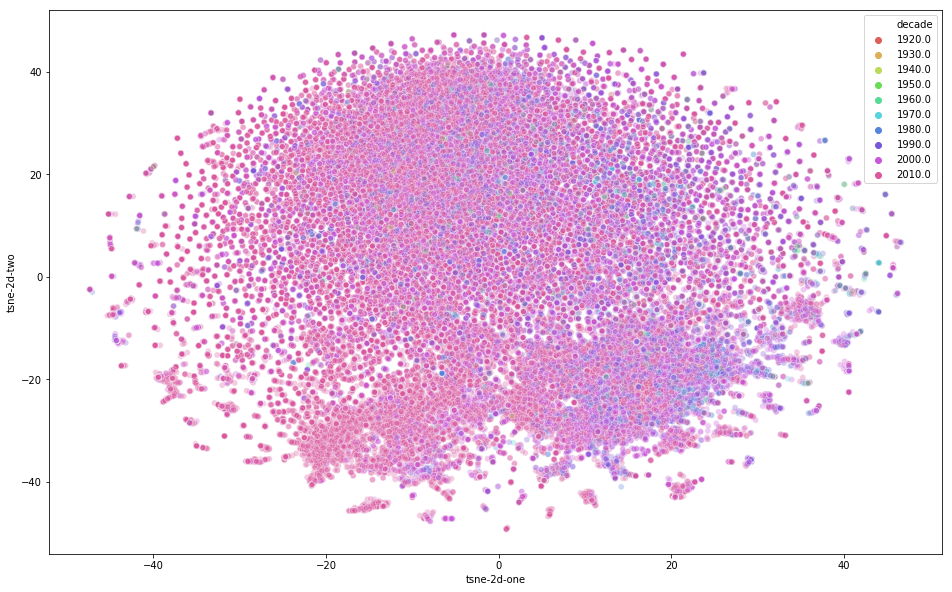

In [100]:
df_subset['tsne-2d-one'] = tsne_results[:,0]
df_subset['tsne-2d-two'] = tsne_results[:,1]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="decade",
    palette=sns.color_palette("hls", 10),
    data=df_subset,
    legend="full",
    alpha=0.3
)